In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
from glob import glob
from tqdm import tqdm_notebook as tqdm
import math

# helper libraries
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.ion()   # interactive mode

# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
BATCHSIZE = 8
PATCHSIZE = 424
SAVEINTERVAL = 2500

In [0]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()

        self.down_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=48, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(num_features=48),
            nn.ReLU(),

            nn.Conv2d(in_channels=48, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
        )
        
        self.down_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        )
        
        self.flat_conv = nn.Sequential(    
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        ) 
        
        self.up_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
           
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
        )
        
        self.up_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=128, out_channels=48, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=48),
            nn.ReLU(),
        )
        
        self.up_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=48, out_channels=48, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=48),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=48, out_channels=24, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=24),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=24, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.down_conv1(x)
        x = self.down_conv2(x)
        x = self.flat_conv(x)
        x = self.up_conv1(x)
        x = self.up_conv2(x)
        out = self.up_conv3(x)
        return out


In [0]:
class CustomDataset(Dataset):

    def __init__(self, input_path, target_path, height=424, width=424, transform=None):
        self.transform = transform
        self.input_img = input_path
        self.target_img = target_path
        self.height = height
        self.width = width

    def __len__(self):
        return len(self.input_img)
    
    def preprocess(self, img_path):
        img = Image.open(img_path)
        img = img.convert('L')
        img = img.resize((self.height, self.width))
        img = np.asarray(img)
        return img

    def __getitem__(self, index):
        
        X = self.preprocess(self.input_img[index])
        y = self.preprocess(self.target_img[index])

        if self.transform:
            X = self.transform(X)
            y = self.transform(y)

        return X, y

In [0]:
root = os.path.join('drive','My Drive','dl_data','rough-sketch-simplification','Data')
Input = os.path.join(root, 'Input')
Target = os.path.join(root,'Target')

In [0]:
height = width = 424

In [0]:
def get_data(Input, Target):
    Targets =sorted(os.listdir(Target))
    Inputs = sorted(os.listdir(Input))
    input_images, target_images = [], []
    for input_image, target_image in zip(Inputs, Targets):
        image_path = os.path.join(Input, input_image)
        target_path = os.path.join(Target, target_image)

        input_images.append(image_path)
        target_images.append(target_path)

    return input_images, target_images

In [0]:
input_images, target_images = get_data(Input, Target)

In [0]:
def show_samples(images):
    fig = plt.figure(figsize=(20, 5))
    columns, rows = 8, 2
    ax = []
    k = 0
    for i in range(columns*rows):
        img = Image.open(images[k])
        k += 1
        # create subplot and append to ax
        ax.append( fig.add_subplot(rows, columns, i+1))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img, cmap="gray")
    plt.tight_layout(True)
    plt.show()  # finally, render the plot

In [0]:
def preprocess(img_path):
    img = Image.open(img_path)
    img = img.convert('L')
    img = img.resize((height, width))
    img = np.asarray(img)
    return img

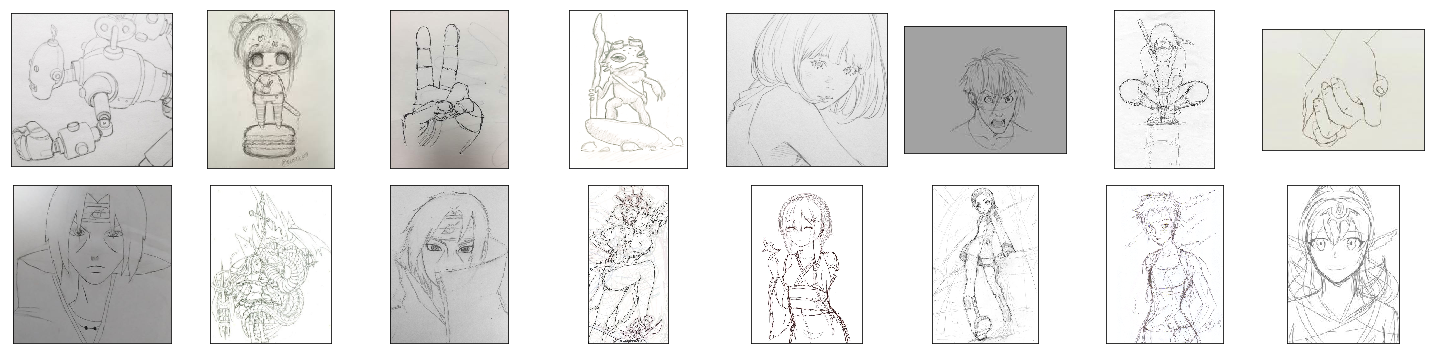

In [15]:
show_samples(input_images)

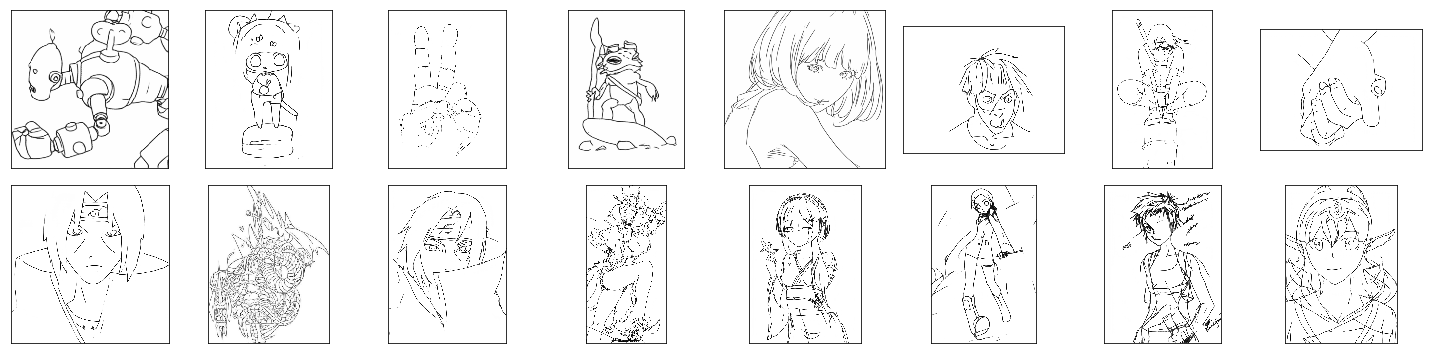

In [16]:
show_samples(target_images)

In [0]:
model = Net()
model.to(device)
optimizer = torch.optim.Adadelta(model.parameters())
criterion = nn.MSELoss().to(device)

In [0]:
transform = transforms.Compose([
                                transforms.ToTensor(),
])

In [0]:
training_set = CustomDataset(input_path=input_images, target_path=target_images, height=height, width=width, transform=transform)
train_loader = DataLoader(training_set, batch_size=8, shuffle=True)

In [0]:
# next(iter(train_loader))

In [0]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [0]:
def train(train_loader, model, criterion, optimizer, epoch, device):
    model.train()
    
    train_loss = AverageMeter()
    
    curr_iter = (epoch - 1) * len(train_loader)
    total_loss_train = []
    for i, data in enumerate(train_loader):
        images, targets = data
        N = images.size(0)
        images = Variable(images).to(device)
        targets = Variable(targets).to(device)
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss.update(loss.item())
        curr_iter += 1
        if epoch % 10 == 0:
            if (i + 1) % 8 == 0:
                print('[epoch %d], [iter %d / %d], [train loss %.5f]' % (
                    epoch, i + 1, len(train_loader), train_loss.avg))
        total_loss_train.append(train_loss.avg)
    return train_loss.avg, total_loss_train

In [0]:
def validate(val_loader, model, criterion, optimizer, epoch, device):
    model.eval()
    val_loss = AverageMeter()
    
    with torch.no_grad():
        for _, data in enumerate(val_loader):
            images, target = data
            N = images.size(0)
            images = Variable(images).to(device)
            target = Variable(target).to(device)
            outputs = model(images)
            val_loss.update(criterion(outputs, target).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f]' % (epoch, val_loss.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [0]:
!mkdir -p pred

In [0]:
def predict(model, img_path):
    model.eval()
    with torch.no_grad():
        in_shape = np.asarray(cv2.imread(img_path)).shape
        img = preprocess(img_path)
        fin_shape = np.asarray(img).shape
        img = transform(img)
        img = Variable(img).to(device)
        img = img.view(1, 1, fin_shape[0],fin_shape[1])
        output = model(img)
        img = ((255*output.cpu().clone().detach().numpy()).squeeze().squeeze())
        img = cv2.resize(img, (in_shape[1],in_shape[0]),interpolation = cv2.INTER_AREA)
        return img


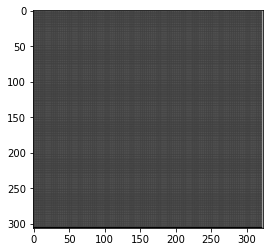

In [27]:
plt.imshow(predict(model, input_images[0]),cmap='gray')

In [0]:
def samples(input_image, target_image, model):
    _,figs = plt.subplots(1,3)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.rcParams['figure.figsize'] = [15, 15]
    figs[0].set_title('Input')
    figs[0].imshow(Image.open(input_image),cmap = 'gray')

    figs[1].set_title('Prediction')
    figs[1].imshow(predict(model, input_image),cmap='gray')

    figs[2].set_title('Target')
    figs[2].imshow(Image.open(target_image),cmap = 'gray')

    plt.show()

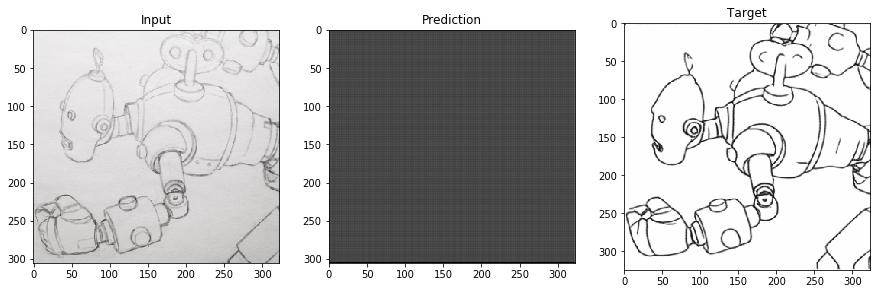

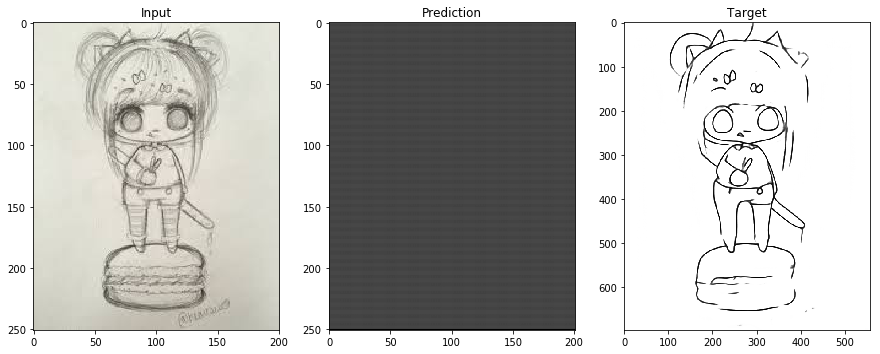

In [30]:
samples(input_images[0], target_images[0], model)
samples(input_images[1], target_images[1], model)

Epoch: 2


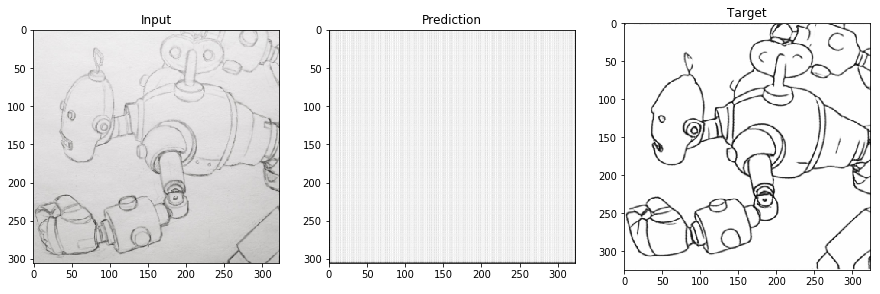

[epoch 10], [iter 8 / 8], [train loss 0.02988]
[epoch 20], [iter 8 / 8], [train loss 0.02720]
Epoch: 20


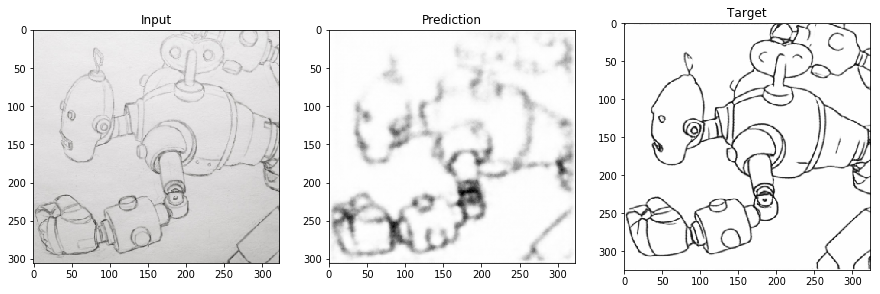

[epoch 30], [iter 8 / 8], [train loss 0.02449]
[epoch 40], [iter 8 / 8], [train loss 0.02102]
Epoch: 40


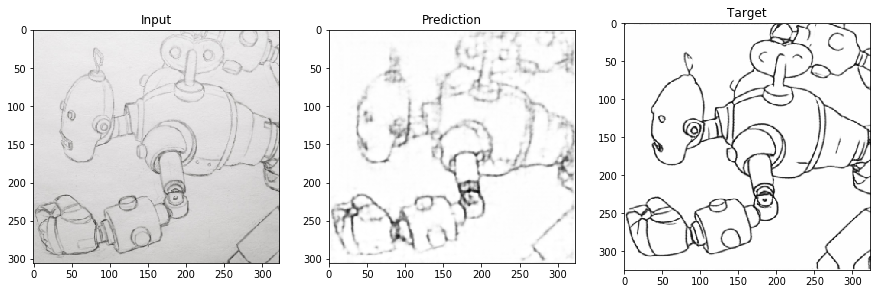

[epoch 50], [iter 8 / 8], [train loss 0.02008]
[epoch 60], [iter 8 / 8], [train loss 0.01647]
Epoch: 60


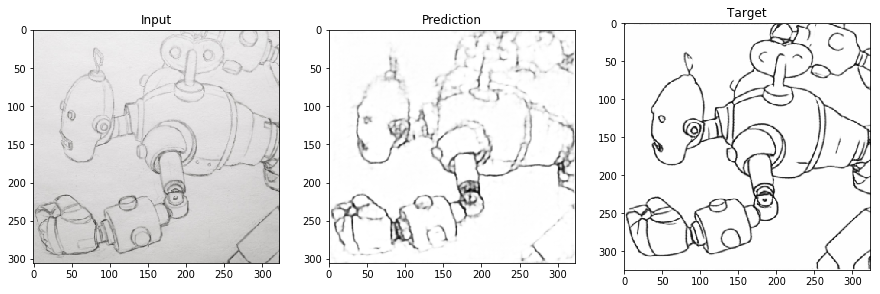

[epoch 70], [iter 8 / 8], [train loss 0.01579]
[epoch 80], [iter 8 / 8], [train loss 0.01777]
Epoch: 80


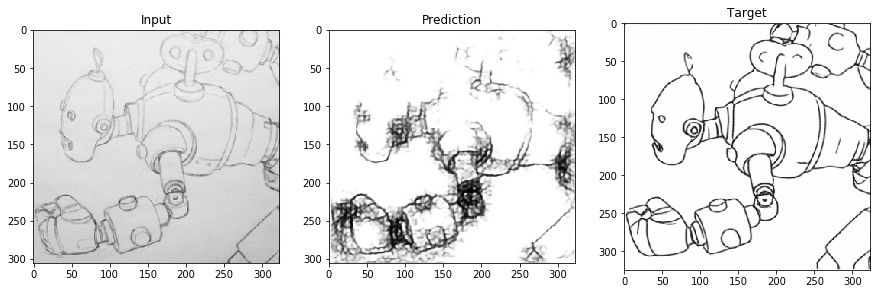

[epoch 90], [iter 8 / 8], [train loss 0.01161]
[epoch 100], [iter 8 / 8], [train loss 0.00956]
Epoch: 100


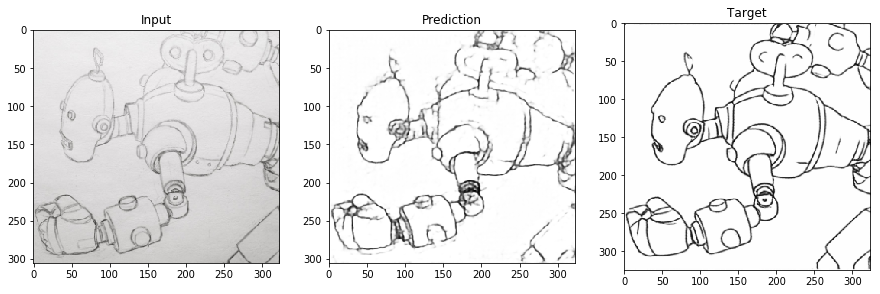

[epoch 110], [iter 8 / 8], [train loss 0.00877]
[epoch 120], [iter 8 / 8], [train loss 0.00839]
Epoch: 120


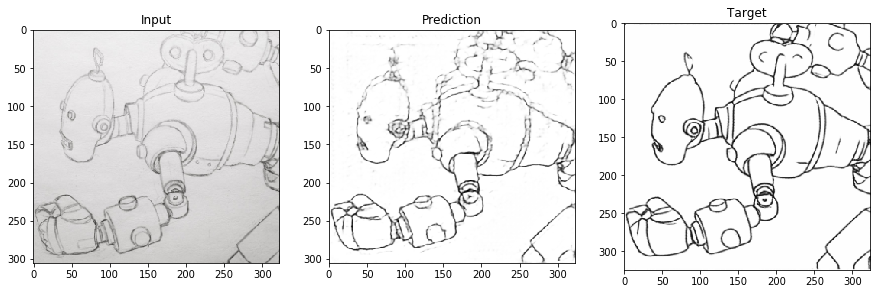

[epoch 130], [iter 8 / 8], [train loss 0.00802]
[epoch 140], [iter 8 / 8], [train loss 0.00607]
Epoch: 140


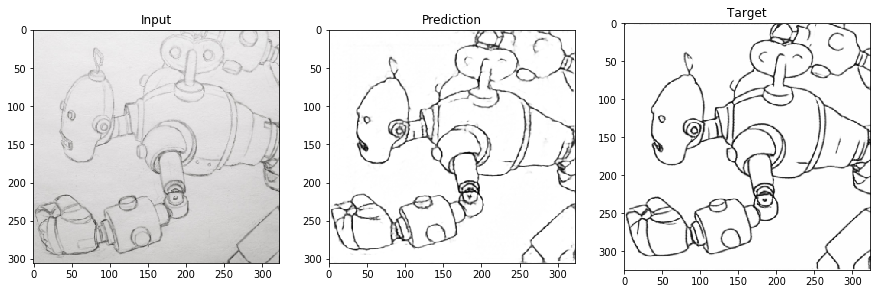

[epoch 150], [iter 8 / 8], [train loss 0.00592]
Time Taken:  3829.3157732486725


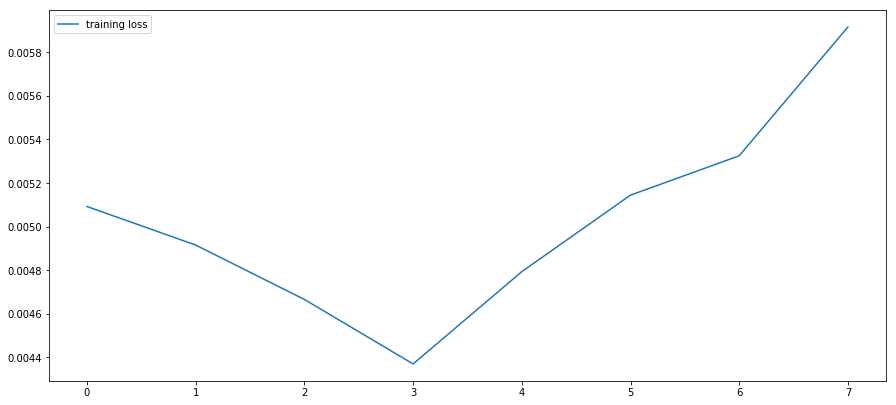

In [31]:
import time
since = time.time()
epoch_num = 150
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, total_loss_train = train(train_loader, model, criterion, optimizer, epoch, device)
    if epoch%20 == 0 or epoch == 2:
        print (f'Epoch: {epoch}')
        samples(input_images[0], target_images[0], model)
        img = predict(model, input_images[0])
        pilimg = Image.fromarray(np.uint8(img))
        pilimg.save('pred/' + str(epoch)+'.png')

print ('Time Taken: ',time.time()-since)
fig = plt.figure(num = 1)
fig1 = fig.add_subplot(2,1,1)
fig1.plot(total_loss_train, label = 'training loss')
plt.legend()
plt.show()


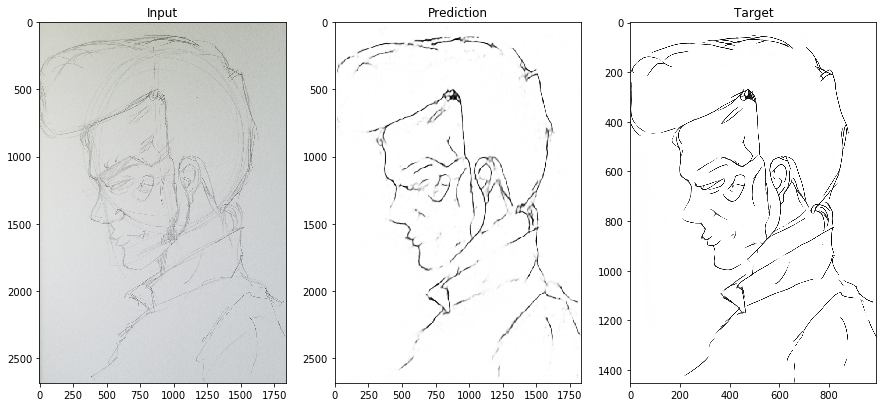

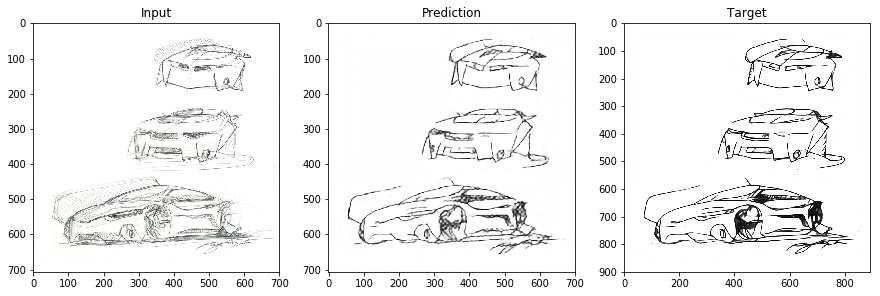

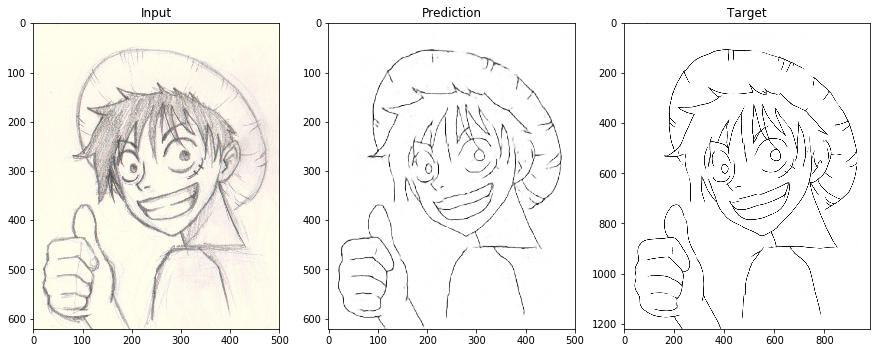

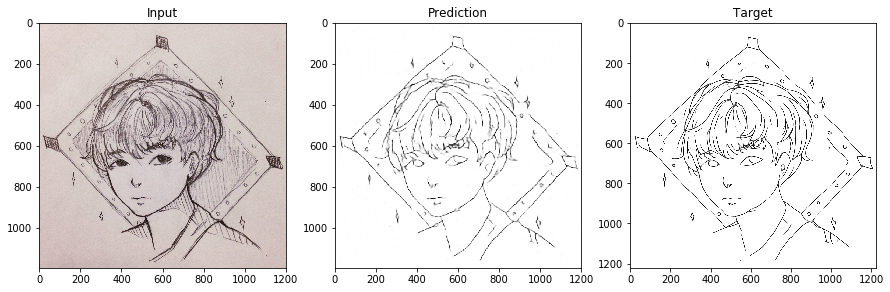

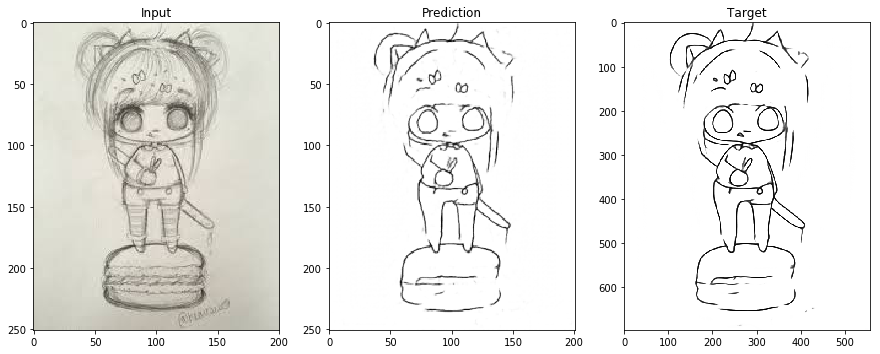

In [32]:
for i in range (5):
    import random
    k = random.randint(1,64)
    samples(input_images[k], target_images[k], model)

In [33]:
!nvidia-smi

Sun Oct  6 02:12:14 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    59W / 149W |   9011MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  